# Exploring Thompson sampling

This post explores using Thompson sampling to solve the same problem presented in the multi-armed bandits benchmark post.

Our problem:
For the next 100 days, we will have 1 hour to play a video games.
We have 20 games, but have no idea which one we will enjoy the most.
How do we decide what to play each day?
We assume that the enjoyment we get from a single hour is random and comes from a beta distribution.
Each game has a different distribution.
Each hour we play of a game gives us an enjoyment value and helps build our knowledge of that game.

We need to compromise exploring which games are enjoyable and sticking to the games we know so far to be good.
This can be represented by a multi-armed bandit problem.

With Thompson sampling we have a Bayesian solution. We propose that the reward from playing each game follows a distribution. We initially don't know that distribution, so we assume it follows some uninformed prior. We can then sample from those distributions once per each game. This gives us some expected reward. Ranking those samples gives us the game to play. Then after playing the game we can update the prior with the reward we received to get a posterior distribution for that game. Repeating this process will allow those posterior distributions to converge to the true underlying distributions.

As we want to select the highest expected reward, once we have a distribution which starts to look good we will increasingly sample from it. Hence we will get more and more data on the games we currently think are better. This can cause issues if we get an unusally bad reward from a game at the start, this would reduce the chance of trying it again.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-whitegrid")

np.random.seed(0)

We setup a class to represent a Game.
This is essentially just a wrapper around a beta distribution.

In [2]:
class Game:
    def __init__(self, a, b) -> None:
        self.a = a
        self.b = b
        self.dist = scipy.stats.beta(a, b)

    def __repr__(self) -> str:
        return f"Game({self.a}, {self.b})"

    def __call__(self, days: int = 1) -> np.ndarray:
        return self.sample(days)

    def sample(self, days: int = 1) -> np.ndarray:
        return self.dist.rvs(days)

    def plot_pdf(self, ax=None) -> plt.figure:
        x = np.linspace(0, 1, 100)
        y = self.dist.pdf(x)

        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 6))
        else:
            fig = None
        ax.plot(x, y)
        return fig

We can plot the distributions of our random 20 games.
There is a lot of overlap and wide distributions.
As such it may not be clear after a single hour if a game is good or not.

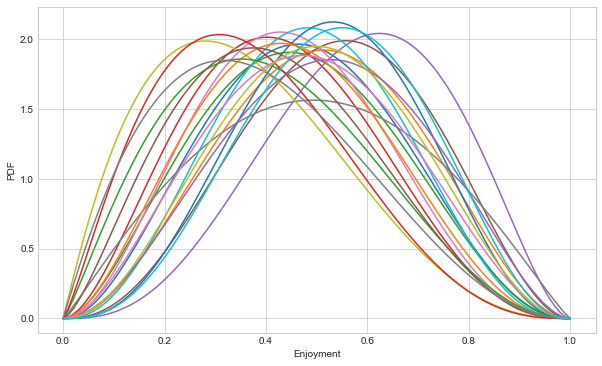

In [3]:
games = []
for idx in range(20):
    games.append(Game(np.random.rand() * 2 + 2, np.random.rand() * 2 + 2))

fig, ax = plt.subplots(figsize=(10, 6))
for game in games:
    fig = game.plot_pdf(ax=ax)
ax.set_xlabel("Enjoyment")
ax.set_ylabel("PDF")
fig

## Thompson Sampling

In [ ]:
class GameEstimate:
    def __init__(self, a, b) -> None:
        self.a = a
        self.b = b
        self.dist = scipy.stats.beta(a, b)

    def __repr__(self) -> str:
        return f"Game({self.a}, {self.b})"

    def __call__(self, days: int = 1) -> np.ndarray:
        return self.sample(days)

    def sample(self, days: int = 1) -> np.ndarray:
        return self.dist.rvs(days)

    def update(self, data:float):
        """Update the prior distribution with data to get posterior."""


    def plot_pdf(self, ax=None) -> plt.figure:
        x = np.linspace(0, 1, 100)
        y = self.dist.pdf(x)

        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 6))
        else:
            fig = None
        ax.plot(x, y)
        return fig

days = 100
strategy = {}
strategy["perfect"] = perfect_strategy(games, days)
strategy["worst"] = worst_strategy(games, days)
strategy["explore"] = exploration_strategy(games, days)

for epsilon_thres in [0.1]:
    epsilon_scores, epsilon_choices = epsilon_strategy(
        games, days, epsilon_thres
    )
    strategy[f"epsilon_{epsilon_thres}"] = epsilon_scores

for explore_threshold in [2]:
    ucb_scores, ucb_choices = ucb_strategy(
        games, days, explore_threshold=explore_threshold
    )
    strategy[f"ucb_{explore_threshold}"] = ucb_scores

## Perfect strategy
With perfect knowledge of the games, this strategy simply selects every time the game with the best expected enjoyment.

In [4]:
def perfect_strategy(games, days):
    # choose best each time
    best_game = np.argmax([game.dist.mean() for game in games])
    return games[best_game].sample(days)

## Worst strategy
With perfect knowledge of the games, this strategy simply selects every time the game with the lowest expected enjoyment.

In [5]:
def worst_strategy(games, days):
    # choose best each time
    best_game = np.argmin([game.dist.mean() for game in games])
    return games[best_game].sample(days)

## Exploration only
We select a random game every time, regardless of what has happened before.

In [6]:
def exploration_strategy(games, days):
    rand_choice = np.random.choice(len(games), days)

    strat_explore = []
    for idx in rand_choice:
        strat_explore.append(games[idx].sample(1))
    return np.array(strat_explore).flatten()

## Epsilon strategy
Each day we decide to either explore or to choice the best game we have seen so far.
We decide which, randomly each time based on some threshold.

In [7]:
def epsilon_strategy(games, days, threshold=0.1):
    previous_samples = {}
    for idx, _ in enumerate(games):
        previous_samples[idx] = []

    choices = []
    strat_epsilon = []
    for idx in range(days):
        if np.random.rand() < threshold:
            # explore
            choice = np.random.choice(len(games), 1)[0]
        else:
            # exploit
            current_mean = [
                np.mean(previous_samples[game]) for game in previous_samples
            ]
            choice = np.argmax(current_mean)

        choices.append(choice)
        sample = games[choice].sample(1)[0]
        strat_epsilon.append(sample)

        # update info
        previous_samples[choice].append(sample)
    # return enjoyement scores and game choices
    return np.array(strat_epsilon).flatten(), np.array(choices).flatten()

## Upper confidence bound strategy
On a given day, we have uncertainty on the observed mean reward we get from each game.
Upper confidence bound (UCB) strategies look to factor this uncertainty in by assuming confidence bounds on the observed mean.
UCB relies on the optimistic notion that the true mean is the observed mean + the uncertainty bound.

Hence with games with less certainty their upper bound can be higher than those we have sampled more.
This promotes more exploration of those uncertain games.
We are more likely to select a game with either a high score, or one with high uncertainty.

As we are dividing by the length of samples taken from each game and taking the log of the iteration number,
this allows the amount of exploration to reduce with time and shifts towards exploitation.

The standard UCB strategies don't assume a particular prior distribution.
There are various extensions to incorporate a prior to formulat a Bayesian UCB strategy.

I've added a constant `explore_threshold` to control the amount of exploration compared to the existing observed average rewards.
This is typically 2, but depending on the scale of the rewards may need adjusting.

In [8]:
def ucb_strategy(games, days, explore_threshold: float = 2):
    previous_samples = {}
    for idx, _ in enumerate(games):
        previous_samples[idx] = []

    choices = []
    strat_ucb = []
    for idx in range(days):
        current_values = [
            np.mean(previous_samples[game])
            + np.sqrt(
                explore_threshold * np.log(idx) / len(previous_samples[game])
            )
            for game in previous_samples
        ]
        choice = np.argmax(current_values)

        choices.append(choice)
        sample = games[choice].sample(1)[0]
        strat_ucb.append(sample)

        # update info
        previous_samples[choice].append(sample)
    # return enjoyement scores and game choices
    return np.array(strat_ucb).flatten(), np.array(choices).flatten()

## Running each strategy
We test each strategy over 100 days.

In [9]:
days = 100
strategy = {}
strategy["perfect"] = perfect_strategy(games, days)
strategy["worst"] = worst_strategy(games, days)
strategy["explore"] = exploration_strategy(games, days)

for epsilon_thres in [0.1]:
    epsilon_scores, epsilon_choices = epsilon_strategy(
        games, days, epsilon_thres
    )
    strategy[f"epsilon_{epsilon_thres}"] = epsilon_scores

for explore_threshold in [2]:
    ucb_scores, ucb_choices = ucb_strategy(
        games, days, explore_threshold=explore_threshold
    )
    strategy[f"ucb_{explore_threshold}"] = ucb_scores

/Users/Rich/Developer/miniconda3/envs/data_analysis_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Rich/Developer/miniconda3/envs/data_analysis_env/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/Rich/Developer/miniconda3/envs/data_analysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/Rich/Developer/miniconda3/envs/data_analysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  
/Users/Rich/Developer/miniconda3/envs/data_analysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/Rich/Developer/miniconda3/envs/data_analysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeW

### Results
The perfect strategy sets the upper limit on performance,
whereas the worst case sets the lower limit.
The exploration strategy sets a random benchmark.
Epsilon - 0.5 starts by playing each game for one hour.
Then generally continues to play the best

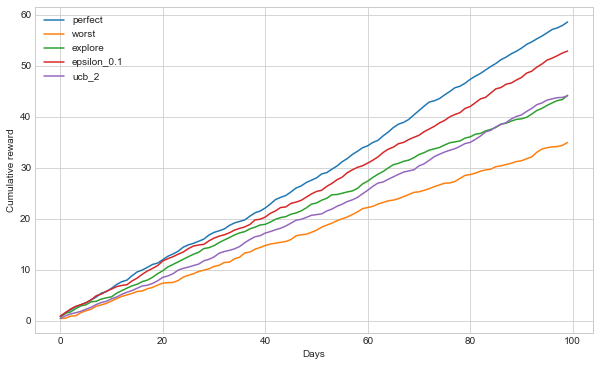

In [10]:
df_strat = pd.DataFrame(strategy)

# plot results
fig, ax = plt.subplots(figsize=(10, 6))
df_strat.cumsum().plot(ax=ax)
ax.set_ylabel("Cumulative reward")
ax.set_xlabel("Days")
plt.show()

## Simulations

As we are sampling from each game's distribution, the results will be random.
Repeating the experiement will give different results.
Indeed, in some cases, we can beat the perfect strategy.
To get a better understanding of the strategy performance we need to simulate the experiment
multiple times in a monte carlo fashion, and use the distribution of the rewards from each.

As such we repeat the experiment 500 times and record the final reward for each strategy.

In [11]:
import tqdm

simulations = []
for idx in tqdm.trange(500):

    strategy = {}
    strategy["perfect"] = perfect_strategy(games, days)
    strategy["worst"] = worst_strategy(games, days)
    strategy["explore"] = exploration_strategy(games, days)

    for epsilon_thres in [0.1]:
        epsilon_results = epsilon_strategy(games, days, epsilon_thres)
        strategy[f"epsilon_{epsilon_thres}"] = epsilon_results[0]
        epsilon_results[1]

    for explore_threshold in [2]:
        ucb_scores, ucb_choices = ucb_strategy(
            games, days, explore_threshold=explore_threshold
        )
        strategy[f"ucb_{explore_threshold}"] = ucb_scores

    df_strat = pd.DataFrame(strategy)
    simulations.append(df_strat.sum())

  0%|          | 0/500 [00:00<?, ?it/s]/Users/Rich/Developer/miniconda3/envs/data_analysis_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Rich/Developer/miniconda3/envs/data_analysis_env/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/Rich/Developer/miniconda3/envs/data_analysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/Rich/Developer/miniconda3/envs/data_analysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  
/Users/Rich/Developer/miniconda3/envs/data_analysis_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/Rich/Developer/miniconda3/envs/data_analysis_env/lib/python3.7/site-pack

We can measure regret as the % difference of the reward relative to the perfect strategy:

In [12]:
df_simulations = pd.DataFrame(simulations)
with pd.option_context("display.float_format", "{:0.3f}".format):
    print(
        (df_simulations["perfect"].mean() - df_simulations.mean())
        / df_simulations["perfect"].mean()
    )

perfect       0.000
worst         0.393
explore       0.204
epsilon_0.1   0.130
ucb_2         0.195
dtype: float64


The results show now that the perfect/worst strategies, as expected, set the extreme performance.
Exploration only gives us a benchmark of acting at random.
A proposed model should perform better than exploration only.

The results will be task dependent.
In this case, the epsilon strategy was fairly successful at increasing the reward.
UCB was somewhat similar to random exploration only.
This could be due to the limit number of days we tested over and the fairly large set of candidate games.
Hence it will explore quite a lot due to the large uncertainty of each game.
This causes it to exploit far less than the epsilon strategy.
The eplison strategy has a parameter to tune the random exploration rate.
In this case a lower value is more beneficial as we don't have too many days to trial,
so exploiting allows for a higher reward.

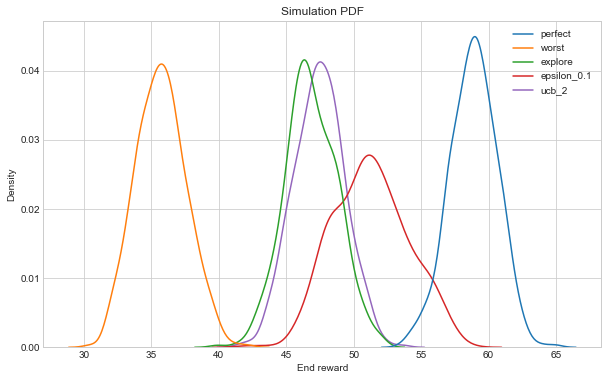

In [13]:
# plot kde
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(data=df_simulations, ax=ax)
ax.set_title("Simulation PDF")
ax.set_xlabel("End reward")
plt.show()